In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-01-27 15:01:03.206724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 15:01:03.398786: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-27 15:01:04.134874: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

In [2]:
MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 

1 Physical GPUs, 1 Logical GPUs


2023-01-27 15:01:13.671949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 15:01:14.421876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [5]:
sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

# Load Koch Meinhardt dataset


In [56]:
from itertools import combinations
from collections import namedtuple

Pattern = namedtuple('Pattern', ['simulation', 't_star', 'x_size', 'y_size', 
                                 'c', 'c_xx', 'c_yy', 'c_t',
                                 'c_domain', 'c_xx_domain', 'c_yy_domain', 'c_t_domain',
                                 'params', 'u_params', 'v_params'])     
def load(sim_name, 
         x_slice,
         y_slice,
         data_time_start=-3, 
         data_time_len=2,
         data_time_step=1,
         verbose=False
        ):
    data_path = os.path.abspath(f"../../test/outputs_Koch_Meinhardt_100_by_100/{sim_name}/{sim_name}.npy")
    with open(data_path, 'rb') as f:
        data = np.load(f)

    data_path = os.path.abspath(f"../../test/outputs_Koch_Meinhardt_100_by_100/{sim_name}/simulation.txt")
    with open(data_path, 'r') as f:
        simulation = eval(f.read())
        
    t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)
    
    if verbose:
        print(f"Initial dataset shape was: {data.shape}.")
    
    L = simulation.L[0]
    x_size = data.shape[1]
    y_size = data.shape[2]
    N = x_size*y_size    
    dxdy = x_size*y_size/L**2
    
       
    if data_time_start+data_time_len+1 < 0:
        time_slice=slice(data_time_start, data_time_start+data_time_len+1, data_time_step)
    else:
        time_slice=slice(data_time_start, data.shape[3], data_time_step)
    data_time_slice=slice(data_time_start, data_time_start+data_time_len, data_time_step)
    
    data_time = data[:, :, :, time_slice].copy()
    data = data[:, :, :, data_time_slice] 
    
    if verbose:
        print(f"It reduced to: {data.shape}.")
    
    t_star_time = t_star[time_slice].copy()
    t_star = t_star[data_time_slice]
    
    assert len(t_star) > 1, f"There must be at least two time steps. There are '{len(t_star)}'."
    
    c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_xx = np.einsum("ctij -> cijt", c_xx)
    c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_yy = np.einsum("ctij -> cijt", c_yy)

    c_t = np.array([[(data_time[c, ..., t+1] -  data_time[c, ..., t])/(t_star_time[t+1] - t_star_time[t])
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_t = np.einsum("ctij -> cijt", c_t)
    
    diff_Y = np.array([[dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    diff_Y = np.einsum("ctij -> cijt", diff_Y)
        
    if verbose:
        print(f"And its X-Y size reduced to: {data[:, x_slice, y_slice, :].shape}.")
        
        
    
        
    params = {"D_u": simulation.Ds[0],
          "D_v": simulation.Ds[1],
          "kappa_u": simulation.parameters["kappa_u"],
          "rho_u": simulation.parameters["rho_u"],
          "mu_u": simulation.parameters["mu_u"],
          "sigma_u": simulation.parameters["sigma_u"],
          "rho_v": simulation.parameters["rho_v"],
          "sigma_v": simulation.parameters["sigma_v"]}
    
    u_params = {k: params[k] for k in ("D_u", "kappa_u", "rho_u", "mu_u", "sigma_u")}
    v_params = {k: params[k] for k in ("D_v", "kappa_u", "rho_v", "sigma_v")}
    
    c_restricted = data[:, x_slice, y_slice, :]
    c_xx_restricted = c_xx[:, x_slice, y_slice, :]
    c_yy_restricted = c_yy[:, x_slice, y_slice, :] 
    c_t_restricted = c_t[:, x_slice, y_slice, :]
    
    
            
    pattern = Pattern(simulation, t_star, x_size, y_size, 
                      c_restricted, c_xx_restricted, c_yy_restricted, c_t_restricted, 
                      data, c_xx, c_yy, c_t,
                      params, u_params, v_params)
        
    return pattern

In [58]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/Koch_Meinhardt_2.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())

x_slice=slice(30,65,4)
y_slice=slice(50,85,4)
pattern = load("Koch_Meinhardt_2", x_slice, y_slice)

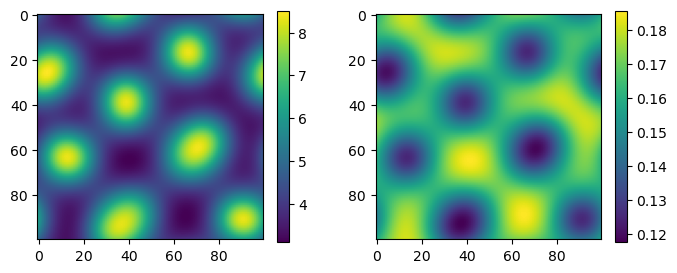

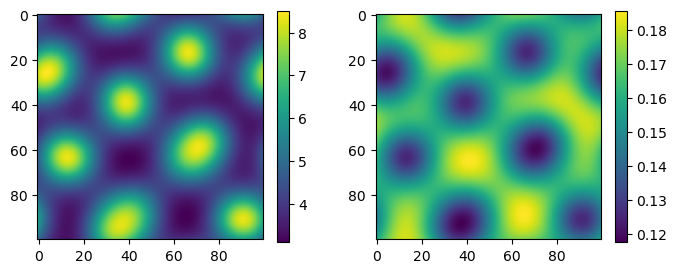

In [60]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(pattern.c_domain[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(pattern.c_domain[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(pattern.c_domain[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(pattern.c_domain[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

In [62]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
indices_sub = indices_all[:, x_slice, y_slice]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]

model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': None,
                'derivatives':[pattern.c_xx_domain, pattern.c_yy_domain, pattern.c_t_domain], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(pattern.c_domain, pattern.t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']
obs_outputs = dataset['obs_output']
obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs

In [63]:
ds = TINN_Dataset(tf.float32, obs_X, pde_X)

In [64]:
ds.sizes

array([162, 162])

In [13]:
#layers = [3, 512, 512, 512, 512, 512, 2]
layers = [3, 128, 128, 128, 128, 128, 2]

obs_loss = Observation_Loss(layers,regularise=True, loss_grad_type=  Loss_Grad_Type.PINN)

In [11]:
pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)

#pbc_loss = Periodic_Boundary_Condition(regularise=True)

modelKM = tu.TINN_Inverse(pinnKM, 
                  losses= [ obs_loss],
                  norm = L2(),
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-4), #keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")

In [12]:
#for element in obs_X[:,:2]:#ds:
    #print(pinnKM.net(element[0][:2]))
#print(pinnKM.net(obs_X[:,:2].astype(np.float32)).numpy())
#print(obs_X[:,2:])
#print(np.abs(pinnKM.net(obs_X[:,:2].astype(np.float32)).numpy() - obs_X[:,2:]))
print(np.max(np.abs(pinnKM.net(obs_X[:,:3].astype(np.float32)).numpy() - obs_X[:,3:])))
print(np.mean(np.abs(pinnKM.net(obs_X[:,:3].astype(np.float32)).numpy() - obs_X[:,3:])))
print()
print(np.mean((pinnKM.net(obs_X[:,:3].astype(np.float32)).numpy()[:,0] - obs_X[:,3])**2))
print(np.mean((pinnKM.net(obs_X[:,:3].astype(np.float32)).numpy()[:,1] - obs_X[:,4])**2))

8.421479529258583
2.582117409665657

26.721774522179793
0.05188671493604124


2023-01-27 14:41:30.665304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [13]:
results_KM = modelKM.train(epochs = 20000+1,
                          batch_size = 81,
                          dataset = ds,
                          print_interval=5000,
                          stop_threshold = 1e-12,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=100)


Start of epoch 0
total loss: 54.740716934204, total regularised loss: 54.740715026855
Observation_Loss -> 
(1)  obs u: 27.316242218018 (2)  obs v: 0.054116186919 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 
Time taken: 3.42s

Start of epoch 5000
total loss: 0.000189091748, total regularised loss: 0.000300260901
Observation_Loss -> 
(1)  obs u: 0.000079478414 (2)  obs v: 0.000015067461 
(1) lambdas : 1.867567896843 (2) lambdas : 0.132432177663 
Time taken: 128.50s

Start of epoch 10000
total loss: 0.000864573783, total regularised loss: 0.001392404549
Observation_Loss -> 
(1)  obs u: 0.000428599436 (2)  obs v: 0.000003687455 
(1) lambdas : 1.658990859985 (2) lambdas : 0.341009110212 
Time taken: 128.35s

Start of epoch 15000
total loss: 0.000385379819, total regularised loss: 0.000646082219
Observation_Loss -> 
(1)  obs u: 0.000191785977 (2)  obs v: 0.000000903939 
(1) lambdas : 1.714599251747 (2) lambdas : 0.285400807858 
Time taken: 132.76s

Start of epoch 20000
total 

In [15]:
results_KM = modelKM.train(epochs = 20000+1,
                          batch_size = 81,
                          dataset = ds,
                          print_interval=500,
                          stop_threshold = 9e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=100)


Start of epoch 0
total loss: 0.000484904958, total regularised loss: 0.000861101551
Observation_Loss -> 
(1)  obs u: 0.000241453323 (2)  obs v: 0.000000999153 
(1) lambdas : 1.782262563705 (2) lambdas : 0.217737674713 
Time taken: 0.17s
############################################
#               Early stop                 #
############################################


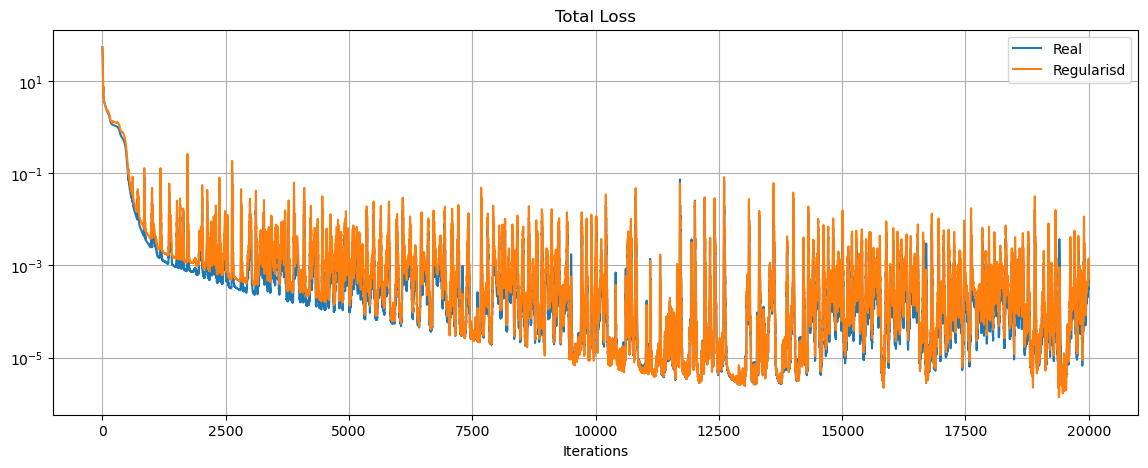

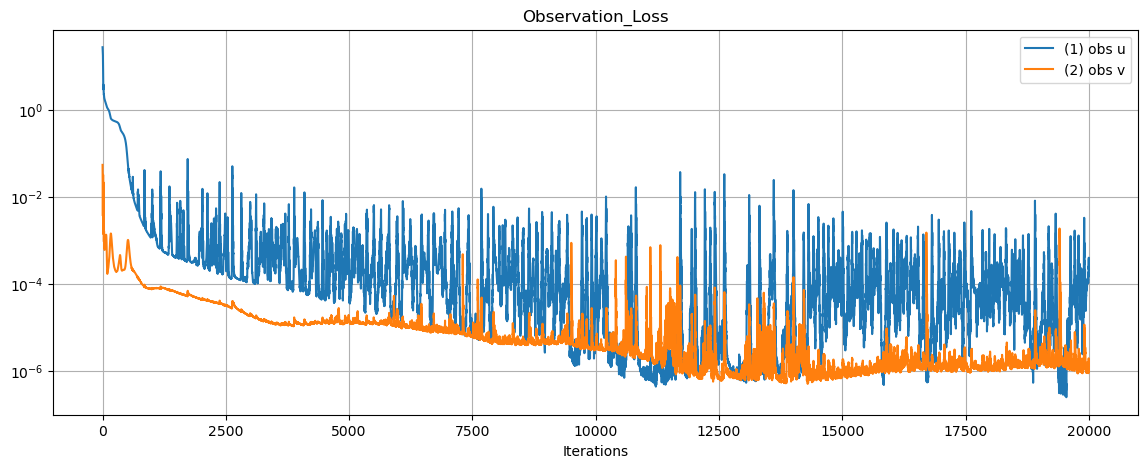

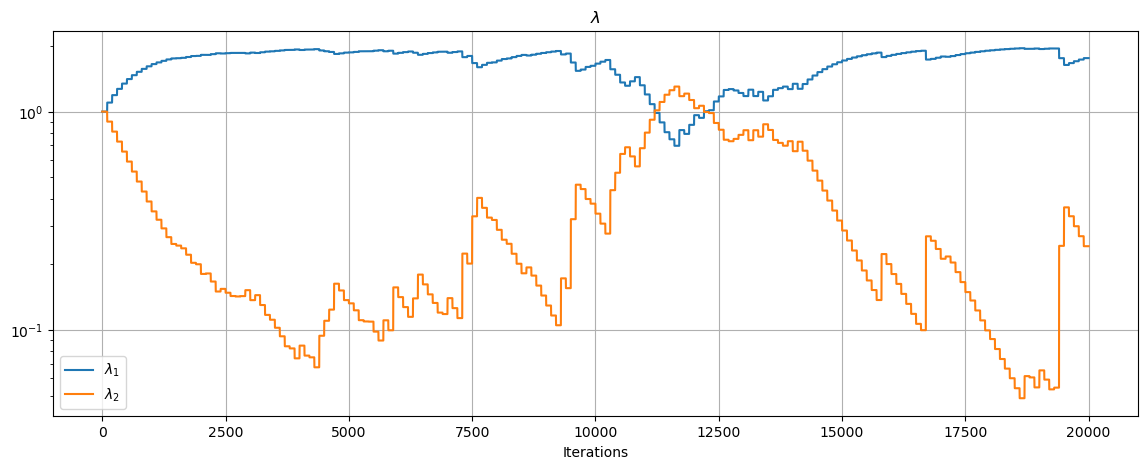

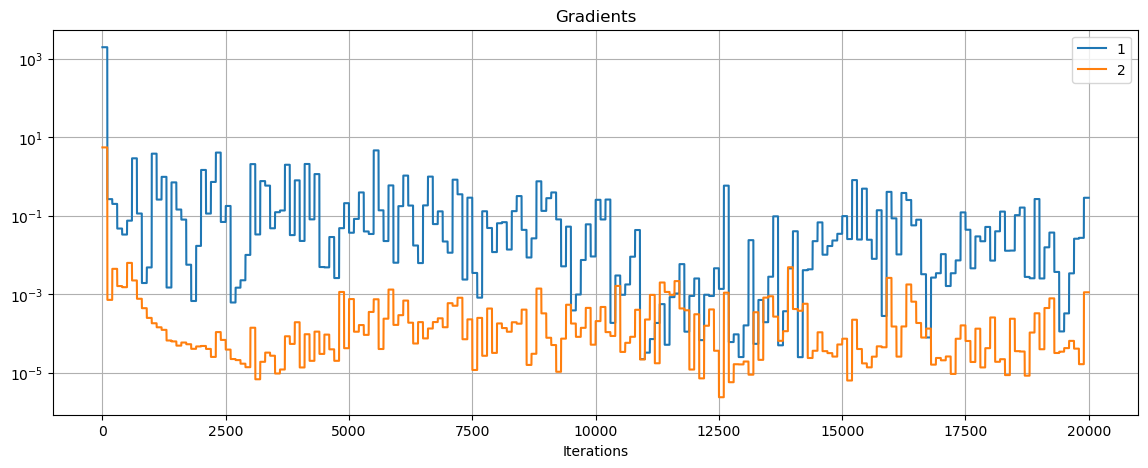

In [14]:
plot_result(merge_dict(results_KM,), modelKM, start=0)

In [14]:
#pinnKM.save(".", "pinn")
pinnKM = tu.NN.restore(".", "pinn")

In [15]:
@tf.function
def derivatives(pinn, x):
    return obs_loss.derivatives(pinn, x)

2023-01-27 16:21:11.399210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


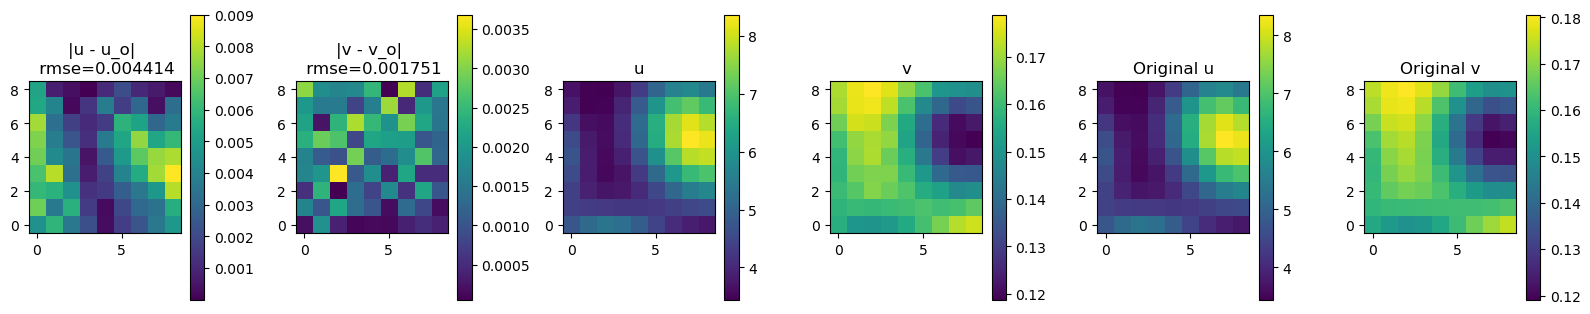

In [16]:
def p(m1, m2, m3, m4, t1="u", t2="v"):
    _ = plt.figure(figsize=(16,6))
    plt.subplot(161)
    rmse = np.sqrt(np.mean((m1 - m3)**2))
    plt.title(f"|{t1} - {t1}_o| \n rmse={rmse:.6f}")
    plt.imshow((np.abs(m1 - m3)), origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(162)
    rmse = np.sqrt(np.mean((m2 - m4)**2))
    plt.title(f"|{t2} - {t2}_o| \n rmse={rmse:.6f}")
    plt.imshow((np.abs(m2 - m4)), origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(163)
    plt.title(f"{t1}")
    plt.imshow(m1, origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(164)
    plt.title(f"{t2}")
    plt.imshow(m2, origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(165)
    plt.title(f"Original {t1}")
    plt.imshow(m3, origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(166)
    plt.title(f"Original {t2}")
    plt.imshow(m4, origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()


test_d = obs_X[:,:3].astype(np.float32)
y, u,  u_xx, u_yy, u_t, v,  v_xx, v_yy, v_t = derivatives(pinnKM, test_d)
# D_u = pde_resKM.D_u.get_value(test_d)
# D_v = pde_resKM.D_v.get_value(test_d)
# sigma_u = pde_resKM.sigma_u.get_value(test_d) #/ pde_resKM.alpha_u
# sigma_v = pde_resKM.sigma_v.get_value(test_d) #/ pde_resKM.alpha_v
# mu_u = pde_resKM.mu_u.get_value(test_d)
# rho_u = pde_resKM.rho_u.get_value(test_d) ##* pde_resKM.alpha_u * pde_resKM.alpha_v
# rho_v = pde_resKM.rho_v.get_value(test_d) #* pde_resKM.alpha_u * pde_resKM.alpha_u
# kappa_u = pde_resKM.kappa_u.get_value(test_d)

def as_patch(m):
    if isinstance(m, np.ndarray):
        return m[block_size:].reshape(block_x, block_y).T
    else:
        return m.numpy()[block_size:].reshape(block_x, block_y).T

u = as_patch(u)
v = as_patch(v)
u_xx = as_patch(u_xx)
v_xx = as_patch(v_xx)
u_yy = as_patch(u_yy)
v_yy = as_patch(v_yy)
u_t = as_patch(u_t)
v_t = as_patch(v_t)

u_obs = as_patch(obs_X[:,3])
v_obs = as_patch(obs_X[:,4])
#u_xx_obs = as_patch(der_u_outputs[:,0])
#u_yy_obs = as_patch(der_u_outputs[:,1])
#u_t_obs = as_patch(der_u_outputs[:,2])
#v_xx_obs = as_patch(der_v_outputs[:,0])
#v_yy_obs = as_patch(der_v_outputs[:,1])
#v_t_obs = as_patch(der_v_outputs[:,2])


p(u, v, u_obs, v_obs)
#p(u_xx, u_yy, u_xx_obs, u_yy_obs,"u_xx", "u_yy")
#p(v_xx, v_yy, v_xx_obs, v_yy_obs,"v_xx", "v_yy")
#p(diff_u, diff_v, diff_u_obs, diff_v_obs,r"$\nabla^2 u$", r"$\nabla^2 v$")
#p(u_t, v_t, u_t_obs, v_t_obs,"u_t", "v_t")


In [17]:
pde_resKM = Koch_Meinhard(
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.1,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.1,dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 0.125,dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.1,dtype=pinnKM.dtype),
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 0.2,dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),
                   regularise=False,
                   loss_grad_type=  Loss_Grad_Type.PARAMETER
    )

modelKM2 = tu.TINN_Inverse(pinnKM.copy(), 
                  losses= [pde_resKM],
                  norm = L2(),
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-4), #keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
ds2 = TINN_Dataset(tf.float32, pde_X)
results_KM2 = modelKM2.train(epochs = 10000+1,
                          batch_size = 81,
                          dataset = ds2,
                          print_interval=100,
                          stop_threshold = 1e-12,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=100)


Start of epoch 0
total loss: 1.538056969643, total regularised loss: 1.538056969643
Loss_Koch_Meinhard -> 
(1)  res u: 0.417047917843 (2)  res v: 0.351980552077 
sigma_u: 1.09914 sigma_v: 0.20100 mu_u: 1.09907 rho_u: 1.10097 
rho_v: 0.12400 
Time taken: 6.90s

Start of epoch 100
total loss: 1.184652984142, total regularised loss: 1.184653043747
Loss_Koch_Meinhard -> 
(1)  res u: 0.406824305654 (2)  res v: 0.185502193868 
sigma_u: 1.01616 sigma_v: 0.26911 mu_u: 1.12784 rho_u: 1.15856 
rho_v: 0.05738 
Time taken: 2.89s

Start of epoch 200
total loss: 1.172979891300, total regularised loss: 1.172979831696
Loss_Koch_Meinhard -> 
(1)  res u: 0.404463395476 (2)  res v: 0.182026527822 
sigma_u: 0.96916 sigma_v: 0.28419 mu_u: 1.14489 rho_u: 1.18955 
rho_v: 0.04784 
Time taken: 2.96s

Start of epoch 300
total loss: 1.172040283680, total regularised loss: 1.172040224075
Loss_Koch_Meinhard -> 
(1)  res u: 0.404113680124 (2)  res v: 0.181906476617 
sigma_u: 0.94849 sigma_v: 0.29064 mu_u: 1.15121 


Start of epoch 3200
total loss: 1.170981347561, total regularised loss: 1.170981407166
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074862599 (2)  res v: 0.181415818632 
sigma_u: 0.94261 sigma_v: 0.34502 mu_u: 1.15600 rho_u: 1.20884 
rho_v: 0.06074 
Time taken: 2.97s

Start of epoch 3300
total loss: 1.170981347561, total regularised loss: 1.170981407166
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074862599 (2)  res v: 0.181415826082 
sigma_u: 0.94275 sigma_v: 0.34502 mu_u: 1.15608 rho_u: 1.20890 
rho_v: 0.06074 
Time taken: 2.97s

Start of epoch 3400
total loss: 1.170981347561, total regularised loss: 1.170981407166
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074847698 (2)  res v: 0.181415840983 
sigma_u: 0.94289 sigma_v: 0.34502 mu_u: 1.15616 rho_u: 1.20896 
rho_v: 0.06074 
Time taken: 3.22s

Start of epoch 3500
total loss: 1.170981347561, total regularised loss: 1.170981407166
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074862599 (2)  res v: 0.181415833533 
sigma_u: 0.94304 sigma_v: 0.34502 mu_u: 1.


Start of epoch 6400
total loss: 1.170980930328, total regularised loss: 1.170980930328
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074519873 (2)  res v: 0.181415952742 
sigma_u: 0.94695 sigma_v: 0.34503 mu_u: 1.15827 rho_u: 1.21061 
rho_v: 0.06073 
Time taken: 2.92s

Start of epoch 6500
total loss: 1.170981049538, total regularised loss: 1.170981049538
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074564576 (2)  res v: 0.181415952742 
sigma_u: 0.94708 sigma_v: 0.34503 mu_u: 1.15833 rho_u: 1.21066 
rho_v: 0.06073 
Time taken: 2.88s

Start of epoch 6600
total loss: 1.170981049538, total regularised loss: 1.170981049538
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074564576 (2)  res v: 0.181415960193 
sigma_u: 0.94720 sigma_v: 0.34503 mu_u: 1.15840 rho_u: 1.21071 
rho_v: 0.06073 
Time taken: 2.91s

Start of epoch 6700
total loss: 1.170980930328, total regularised loss: 1.170980930328
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074519873 (2)  res v: 0.181415967643 
sigma_u: 0.94732 sigma_v: 0.34503 mu_u: 1.


Start of epoch 9600
total loss: 1.170980572701, total regularised loss: 1.170980572701
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074326158 (2)  res v: 0.181415960193 
sigma_u: 0.95064 sigma_v: 0.34503 mu_u: 1.16019 rho_u: 1.21212 
rho_v: 0.06073 
Time taken: 2.93s

Start of epoch 9700
total loss: 1.170980572701, total regularised loss: 1.170980572701
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074326158 (2)  res v: 0.181415960193 
sigma_u: 0.95075 sigma_v: 0.34503 mu_u: 1.16025 rho_u: 1.21217 
rho_v: 0.06073 
Time taken: 2.96s

Start of epoch 9800
total loss: 1.170980572701, total regularised loss: 1.170980572701
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074341059 (2)  res v: 0.181415960193 
sigma_u: 0.95087 sigma_v: 0.34503 mu_u: 1.16031 rho_u: 1.21221 
rho_v: 0.06073 
Time taken: 2.92s

Start of epoch 9900
total loss: 1.170980513096, total regularised loss: 1.170980453491
Loss_Koch_Meinhard -> 
(1)  res u: 0.404074296355 (2)  res v: 0.181415952742 
sigma_u: 0.95097 sigma_v: 0.34503 mu_u: 1.

In [30]:
simulation.parameters

{'kappa_u': 0.0,
 'mu_u': 1.0,
 'rho_u': 1.0,
 'rho_v': 0.025,
 'sigma_u': 1.0,
 'sigma_v': 0.1}

In [18]:
import pathlib
import pickle

In [19]:
path = pathlib.PurePath("/end/home/rh2310/morpho_repo/Loss_landscape").joinpath("Koch_Meinhardt_2_results")
with open(f"{str(path)}_data.pkl", "wb") as f:
    pickle.dump(results_KM2, f)

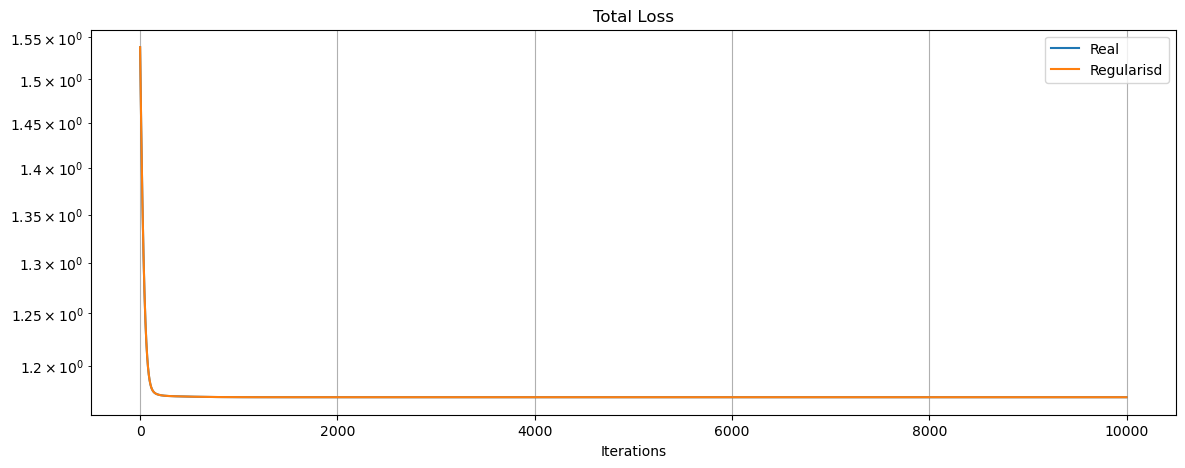

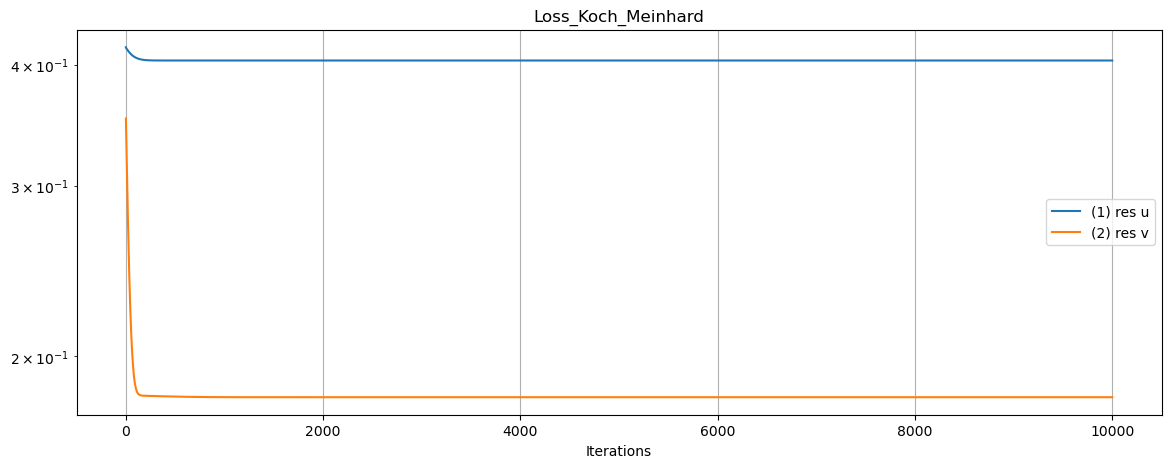

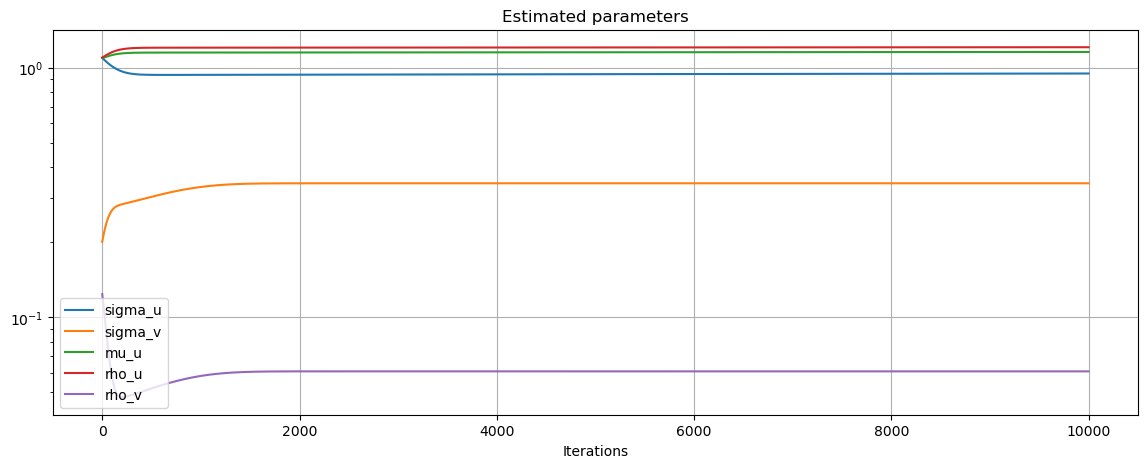

In [27]:
plot_result(merge_dict(results_KM2,), modelKM2, start=0, 
            param_names=pde_resKM.parameter_names())

In [22]:
def norm_params(pde_resKM, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = (pde_resKM.sigma_u.get_value(test_d) / pde_resKM.alpha_u).numpy()
    sigma_v = (pde_resKM.sigma_v.get_value(test_d) / pde_resKM.alpha_v).numpy()
    mu_u = (pde_resKM.mu_u.get_value(test_d)).numpy()
    rho_u = (pde_resKM.rho_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_v).numpy()
    rho_v = (pde_resKM.rho_v.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u).numpy()
    kappa_u = (pde_resKM.kappa_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u).numpy()
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + (sigma_v-sigma_v2)**2 +(mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + (rho_v-rho_v2)**2 +(kappa_u-kappa_u2)**2
           )
    
def norm_params2(result, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = result["sigma_u"] if "sigma_u" in result.keys() else simulation.parameters["sigma_u"]
    sigma_v =  result["sigma_v"] if "sigma_v" in result.keys() else simulation.parameters["sigma_v"]
    mu_u = result["mu_u"] if "mu_u" in result.keys() else simulation.parameters["mu_u"]
    rho_u = result["rho_u"] if "rho_u" in result.keys() else simulation.parameters["rho_u"]
    rho_v = result["rho_v"] if "rho_v" in result.keys() else simulation.parameters["rho_v"]
    kappa_u = result["kappa_u"] if "kappa_u" in result.keys() else simulation.parameters["kappa_u"]
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + 
            (sigma_v-sigma_v2)**2 +
            (mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + 
            (rho_v-rho_v2)**2 +
            (kappa_u-kappa_u2)**2
           )
        

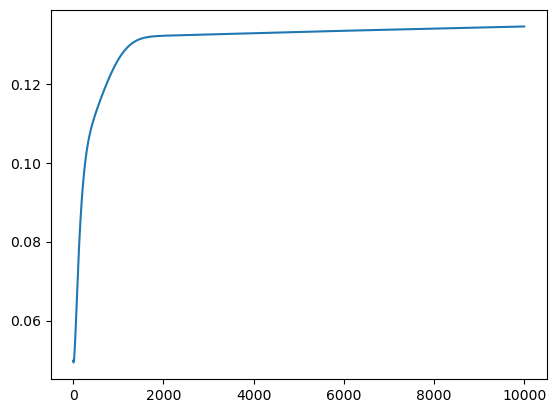

In [23]:
plt.plot(norm_params2(merge_dict(results_KM2,) 
                      ,simulation))

# Second test: No fixed parameter but more data for training

In [24]:
print(pde_resKM.trainables_str())

sigma_u: 0.95108 sigma_v: 0.34503 mu_u: 1.16042 rho_u: 1.21230 
rho_v: 0.06073 


In [71]:
pattern.params

{'D_u': 0.1,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 1.0,
 'mu_u': 1.0,
 'sigma_u': 1.0,
 'rho_v': 0.025,
 'sigma_v': 0.1}

In [103]:
print(f"Network output error:{np.sqrt(np.mean((u-obs_X[:,3])**2)) + np.sqrt(np.mean((v-obs_X[:,4])**2))}")

Network output error:0.034984126687049866


In [104]:
u_actual = obs_X[:,3]#.reshape((9,9,2))
v_actual = obs_X[:,4]#.reshape((9,9,2))
f_actual = u_actual * u_actual * v_actual / (1.0 + pattern.params["kappa_u"] * u_actual * u_actual)

f_u_actual =( pattern.params["D_u"] * (dataset['der_u'][0,:] + dataset['der_u'][1,:]) 
            + pattern.params["rho_u"] * f_actual 
            - pattern.params["mu_u"] * u_actual
            + pattern.params["sigma_u"] 
            - dataset['der_u'][2,:])
f_v_actual = ( pattern.params["D_v"] * (dataset['der_v'][0,:] + dataset['der_v'][1,:]) 
             - pattern.params["rho_v"] * f_actual 
             + pattern.params["sigma_v"]
             - dataset['der_v'][2,:]
             )
print(f"Actual Residual error:{np.sqrt(np.mean(f_u_actual**2)) + np.sqrt(np.mean(f_v_actual**2))}")

Actual Residual error:1.819953062147788e-06


In [110]:
test_d = obs_X[:,:3].astype(np.float32)

In [111]:
y, u,  u_xx, u_yy, u_t, v,  v_xx, v_yy, v_t = derivatives(pinnKM, test_d)

In [119]:
f_coef = u * u * v / (1.0 + pattern.params["kappa_u"] * u * u)
f_u_coef = (pattern.params["D_u"] * (dataset['der_u'][0,:] + dataset['der_u'][1,:]) 
       + pattern.params["rho_u"] * f_coef 
       - pattern.params["mu_u"] * u 
       + pattern.params["sigma_u"]
       - dataset['der_u'][2,:])
f_v_coef =( pattern.params["D_v"] * (dataset['der_v'][0,:] + dataset['der_v'][1,:]) 
     - pattern.params["rho_v"] * f_coef 
     + pattern.params["sigma_v"]
     - dataset['der_v'][2,:])
print(f"Residual with actual parameter and derivatives:{np.sqrt(np.mean(f_u_coef**2))}") 

Residual with actual parameter and derivatives:0.06815207749605179


In [120]:
u_actual = obs_X[:,3]#.reshape((9,9,2))
v_actual = obs_X[:,4]#.reshape((9,9,2))
f_actual = u_actual * u_actual * v_actual / (1.0 + pattern.params["kappa_u"] * u_actual * u_actual)

f_u_actual =( pattern.params["D_u"] * (u_xx + u_yy) 
            + pattern.params["rho_u"] * f_actual 
            - pattern.params["mu_u"] * u_actual
            + pattern.params["sigma_u"] 
            - u_t)
f_v_actual = ( pattern.params["D_v"] * (v_xx + v_yy) 
             - pattern.params["rho_v"] * f_actual 
             + pattern.params["sigma_v"]
             - v_t
             )
print(f"Residual with actual parameter and u, v:{np.sqrt(np.mean(f_u_actual**2)) + np.sqrt(np.mean(f_v_actual**2))}")

Residual with actual parameter and u, v:4.988504886627197


In [112]:
f_coef = u * u * v / (1.0 + pattern.params["kappa_u"] * u * u)
f_u_coef = (pattern.params["D_u"] * (u_xx + u_yy) 
       + pattern.params["rho_u"] * f_coef 
       - pattern.params["mu_u"] * u 
       + pattern.params["sigma_u"]
       - u_t)
f_v_coef =( pattern.params["D_v"] * (v_xx + v_yy)
     - pattern.params["rho_v"] * f_coef 
     + pattern.params["sigma_v"]
     - v_t)
print(f"Residual with actual parameter:{np.sqrt(np.mean(f_u_coef**2)) + np.sqrt(np.mean(f_v_coef**2))}")

Residual with actual parameter:4.969691276550293


In [113]:
D_u = pde_resKM.D_u.get_value(test_d)
D_v = pde_resKM.D_v.get_value(test_d)
sigma_u = pde_resKM.sigma_u.get_value(test_d)
sigma_v = pde_resKM.sigma_v.get_value(test_d)
mu_u = pde_resKM.mu_u.get_value(test_d)
rho_u = pde_resKM.rho_u.get_value(test_d)
rho_v = pde_resKM.rho_v.get_value(test_d)
kappa_u = pde_resKM.kappa_u.get_value(test_d) 

f = u * u * v / (1.0 + D_u * u * u)
f_u = (D_u * (u_xx + u_yy) 
       + rho_u * f 
       - mu_u * u 
       + sigma_u
       - u_t)
f_v =( D_v * (v_xx + v_yy)
     - rho_v * f 
     + sigma_v
     - v_t)
print(f"Residual :{np.sqrt(np.mean(f_u**2)) + np.sqrt(np.mean(f_v**2))}")

Residual :6.069282054901123


In [31]:
diffusion_u = D_u * (u_xx + u_yy)
diffusion_v = D_v * (v_xx + v_yy)

dxdy = x_size * y_size/ L**2
#diffusion_u_space = D_u * dxdy * diffusion([x_size, y_size], u.numpy().reshape(x_size, y_size))
#diffusion_v_space = D_v * dxdy * diffusion([x_size, y_size], v.numpy().reshape(x_size, y_size))


f = u * u * v / (1.0 + kappa_u * u * u)
non_lin_u = -rho_u * f
non_lin_v = rho_v * f
f_u = - rho_u * f + mu_u * u - sigma_u
f_v = rho_v * f - sigma_v


f_real = u * u * v / (1.0 + simulation.parameters["kappa_u"] * u * u)
f_u_real = - simulation.parameters["rho_u"] * f_real + simulation.parameters["mu_u"] * u - simulation.parameters["sigma_u"]
f_v_real = simulation.parameters["rho_v"] * f_real - simulation.parameters["sigma_v"]

d_t_u = - D_u * (u_xx + u_yy) - rho_u * f + mu_u * u - sigma_u
d_t_v = -D_v * (v_xx + v_yy) + rho_v * f - sigma_v


In [66]:
pattern.c_t.shape

(2, 9, 9, 2)

In [70]:
np.sqrt(np.mean(f_u_actual**2)) + np.sqrt(np.mean(f_v_actual**2))

1.819953062147788e-06

In [51]:
np.sqrt(np.mean(f_u_real**2)) + np.sqrt(np.mean(f_v_real**2))

0.4349001

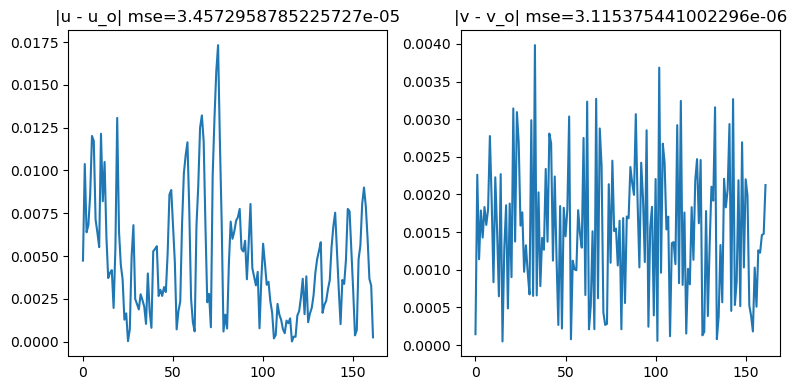

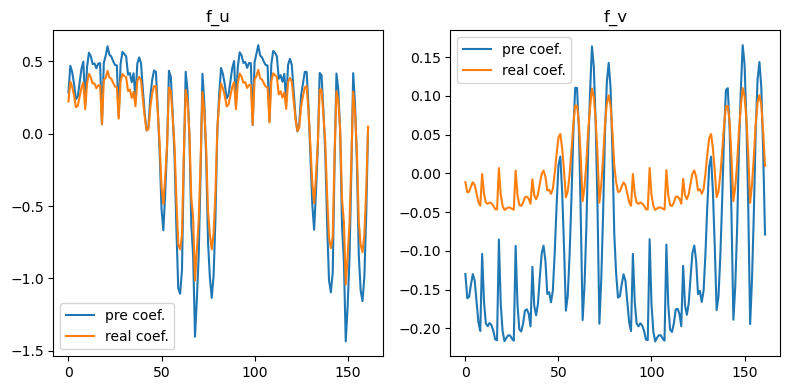

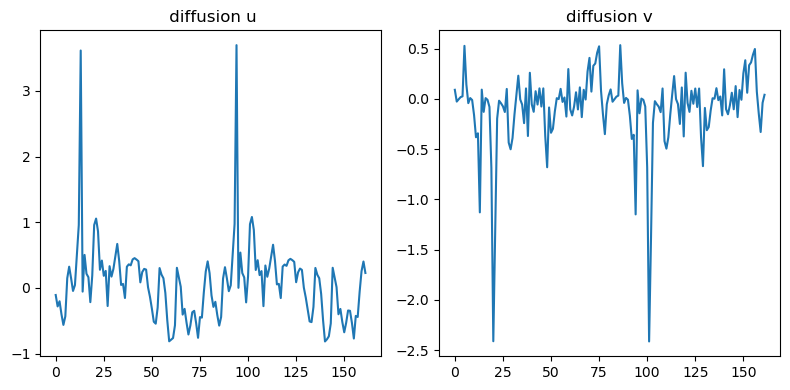

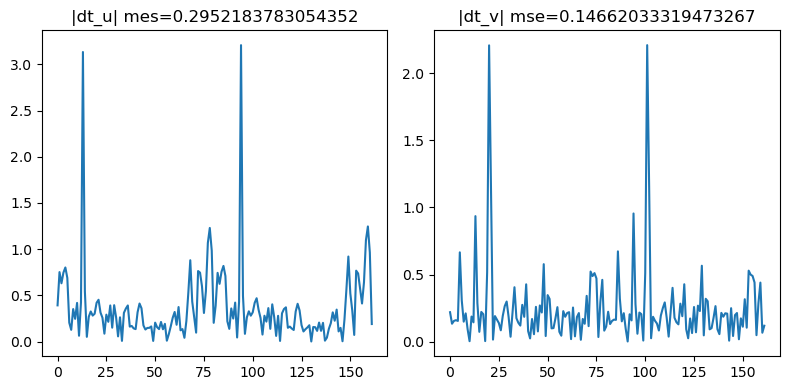

In [32]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
mse = np.mean((u.numpy() - obs_X[:,3])**2)
plt.title(f"|u - u_o| mse={mse}")
plt.plot(np.abs(u.numpy() - obs_X[:,3]))
plt.subplot(122)
mse = np.mean((v.numpy() - obs_X[:,4])**2)
plt.title(f"|v - v_o| mse={mse}")
plt.plot(np.abs(v.numpy() - obs_X[:,4]))
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("f_u")
plt.plot(f_u.numpy(), label="pre coef.")
plt.plot(f_u_real.numpy(), label="real coef.")
plt.legend()
plt.subplot(122)
plt.title("f_v")
plt.plot(f_v.numpy(), label="pre coef.")
plt.plot(f_v_real.numpy(), label="real coef.")
plt.legend()
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title(" diffusion u")
plt.plot(diffusion_u.numpy())
plt.subplot(122)
plt.title("diffusion v")
plt.plot(diffusion_v.numpy())
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
mse = np.mean(d_t_u.numpy()**2)
plt.title(f"|dt_u| mes={mse}")
plt.plot(np.abs(d_t_u.numpy()))
plt.subplot(122)
mse = np.mean(d_t_v.numpy()**2)
plt.title(f"|dt_v| mse={mse}")
plt.plot(np.abs(d_t_v.numpy()))
plt.tight_layout()
plt.show()



In [33]:
from scipy.optimize import lsq_linear

In [41]:
n = ds.sizes[0]
b = np.r_[(simulation.Ds[0]*(u_xx + u_yy)).numpy() - u_t.numpy(), 
          (simulation.Ds[1]*(v_xx + v_yy)).numpy()  - v_t.numpy()]
#b =(-simulation.Ds[0]*(u_xx + u_yy)).numpy() - u_t.numpy()
#b =(-simulation.Ds[1]*(v_xx + v_yy)).numpy() - v_t.numpy()

A = np.vstack((np.c_[f.numpy(), -u.numpy(), [1]*n, [0]*n, [0]*n],
               np.c_[[0]*n, [0]*n, [0]*n, -f.numpy(), [1]*n]))
#A = np.c_[f.numpy(), -u.numpy(), [1]*n]
#A = np.c_[-f.numpy(), [1]*n]


In [42]:
res = lsq_linear(A, b, bounds=(0, np.inf), lsq_solver='lsmr',verbose=1, tol=1e-20, 
                 max_iter=10000,
                 lsmr_tol='auto')#, method='bvls')
res

The maximum number of iterations is exceeded.
Number of iterations 10000, initial cost 1.7845e+03, final cost 1.0483e+03, first-order optimality 1.53e+00.


   active_mask: array([0, 0, 0, 0, 0])
          cost: 1048.3213963234143
           fun: array([-2.20604790e+00, -3.01243164e-01, -1.02924857e+00, -2.08859605e+00,
       -3.26482365e+00, -2.39439672e+00, -8.57518932e-01,  2.27299319e+00,
       -1.99364720e-01, -5.62658813e+00,  2.82539106e-01, -5.80584141e+00,
       -2.50944751e+00, -1.56406309e+00, -1.10250758e-01, -2.02392514e+00,
       -4.34119268e-01, -3.20447745e-01, -8.11718563e+00,  8.98992499e+00,
       -2.13206793e+00,  9.61462114e-01, -2.15291235e+00, -9.09257994e-01,
       -6.72594007e-01, -3.61770286e-01,  7.23203089e-02, -1.13293770e+01,
        9.42442243e+00,  5.19800907e-01,  2.85508296e-01,  3.26380572e-01,
       -2.93906741e+00, -3.71847408e+00, -5.36471252e+00,  1.52815431e+00,
       -1.04339796e+01,  3.55328390e+00,  2.82587334e+00,  5.16299586e-01,
        4.90689700e-01, -2.74155129e+00, -4.06147593e+00, -6.63855164e+00,
        3.77274536e+00, -6.53754049e-01,  2.87811845e+00,  3.54073129e+00,
        6.

In [43]:
print(pde_resKM.trainables_str())

sigma_u: 0.95108 sigma_v: 0.34503 mu_u: 1.16042 rho_u: 1.21230 
rho_v: 0.06073 


In [37]:
simulation.parameters

{'kappa_u': 0.0,
 'mu_u': 1.0,
 'rho_u': 1.0,
 'rho_v': 0.025,
 'sigma_u': 1.0,
 'sigma_v': 0.1}

In [44]:
params = np.array([simulation.parameters['rho_u'], simulation.parameters['mu_u'], 
                   simulation.parameters['sigma_u'],
                   simulation.parameters['rho_v'], simulation.parameters['sigma_v']])



In [45]:
np.mean(((np.dot(A, params)+b))**2)

9.214279933329946

In [46]:
np.mean(((np.dot(A, res.x)+b))**2)

14.182083828237587

In [157]:
obs_X.shape

(2000, 5)